### Assigment 2

#### Step 0

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import torch
import keras
import keras_hub
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import os
import warnings
warnings.filterwarnings('ignore')

2025-11-06 12:31:00.044190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762432260.262482      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762432260.323821      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        match filename:
            case "train.csv":
                train = pd.read_csv(filepath)
            case "test.csv":
                test = pd.read_csv(filepath)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (57477, 9)
Test shape: (3, 4)


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [3]:
print('Train columns: ', train.columns.tolist())
print('\nTarget distribution: ')
print(train[['winner_model_a', 'winner_model_b', 'winner_tie']].sum())

Train columns:  ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie']

Target distribution: 
winner_model_a    20064
winner_model_b    19652
winner_tie        17761
dtype: int64


In [4]:
#quick check if data is damaged
train.isnull()  #null or missing data
test.isnull()

print(test.duplicated().sum()) #duplicates 
print(train.duplicated().sum())

total_id = len(train['id'])   #duplicates in id
total_unique_id = len(train['id'].unique())

print("Total number of 'id' duplicates: ",(total_id - total_unique_id))

0
0
Total number of 'id' duplicates:  0


#### Step 1

In [5]:
#extraxting features
def get_sentence_count(series):
    return series.map(lambda x: x.count('.') + x.count('!') + x.count('?'))

def get_avg_word_len(series):
    return series.map(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)

def get_upper_ratio(series):
    return series.map(lambda x: sum(c.isupper() for c in x) / len(x) if len(x) > 0 else 0)

def get_num_digits(series):
    return series.map(lambda x: len(re.findall(r'\d', x)))

def get_punct_count(series):
    return series.map(lambda x: sum(c in "!?;:," for c in x))

def extract_features(data):
    response_len_a = data['response_a'].map(len)
    response_len_b = data['response_b'].map(len)
    word_count_a = data['response_a'].map(lambda x: len(x.split()))
    word_count_b = data['response_b'].map(lambda x: len(x.split()))
    sentence_count_a = get_sentence_count(data['response_a'])
    sentence_count_b = get_sentence_count(data['response_b'])
    avg_word_len_a = get_avg_word_len(data['response_a'])
    avg_word_len_b = get_avg_word_len(data['response_b'])
    upper_ratio_a = get_upper_ratio(data['response_a'])
    upper_ratio_b = get_upper_ratio(data['response_b'])
    num_digits_a = get_num_digits(data['response_a'])
    num_digits_b = get_num_digits(data['response_b'])
    punct_count_a = get_punct_count(data['response_a'])
    punct_count_b = get_punct_count(data['response_b'])

    data['diff_response_len'] = response_len_a - response_len_b
    data['diff_word_count'] = word_count_a - word_count_b
    data['diff_sentence'] = sentence_count_a - sentence_count_b
    data['diff_avg_word_len'] = avg_word_len_a - avg_word_len_b
    data['diff_upper_ratio'] = upper_ratio_a - upper_ratio_b
    data['diff_num_digits'] = num_digits_a - num_digits_b
    data['diff_punct_count'] = punct_count_a - punct_count_b
    data['prompt_len'] = data['prompt'].map(len)

    return data[['diff_response_len', 'diff_word_count', 'diff_sentence', 'diff_avg_word_len',
                 'diff_upper_ratio','diff_num_digits','diff_punct_count','prompt_len']]

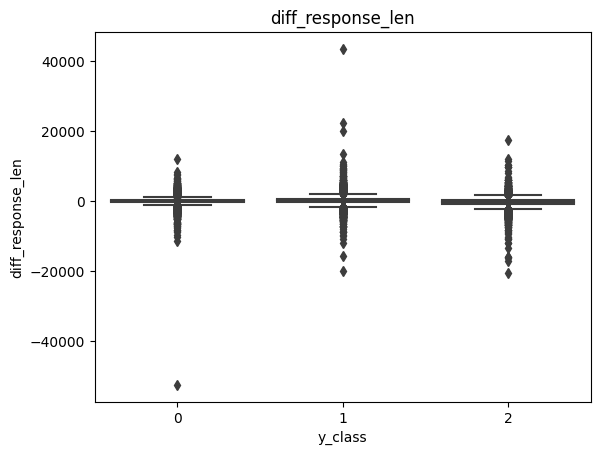

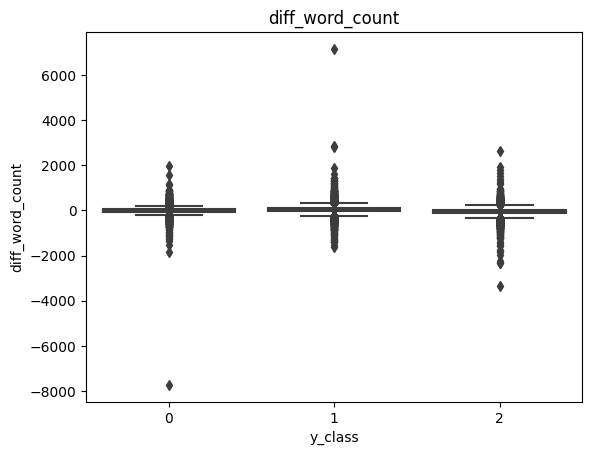

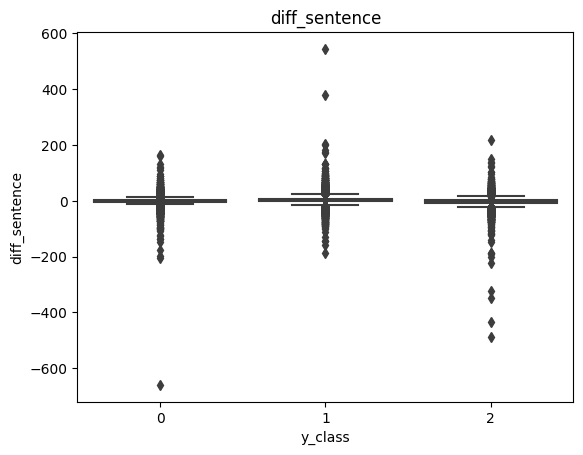

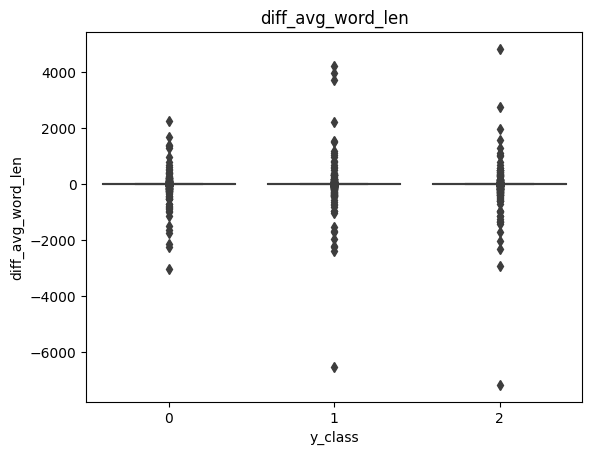

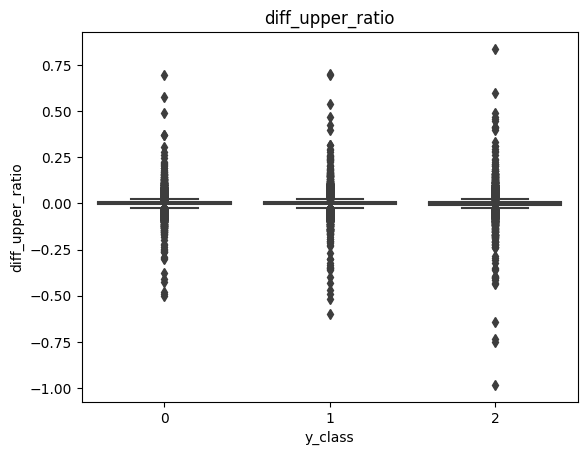

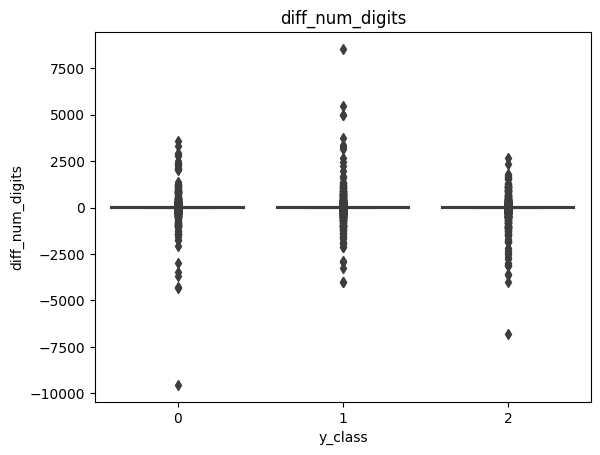

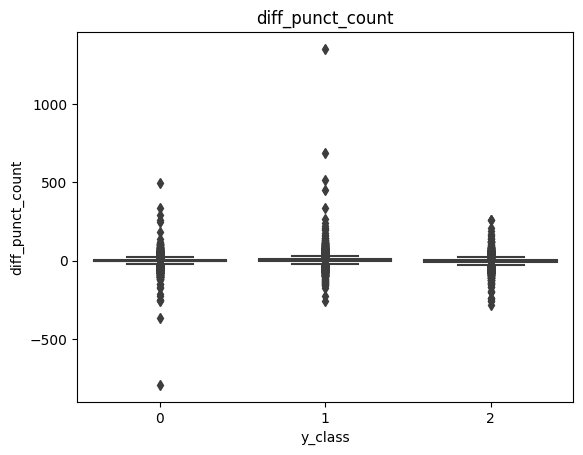

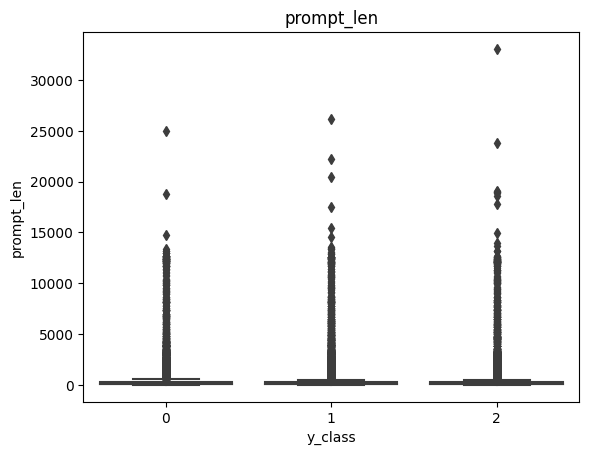

In [6]:
def make_class_label(row):
    if row['winner_tie'] == 1:
        return 0      # tie
    elif row['winner_model_a'] == 1:
        return 1      # model A wins
    elif row['winner_model_b'] == 1:
        return 2      # model B wins

train['y_class'] = train.apply(make_class_label, axis=1)

y = train['y_class']

X = extract_features(train)

import seaborn as sns
import matplotlib.pyplot as plt

for col in X.columns:
    sns.boxplot(x=y, y=X[col])
    plt.title(col)
    plt.show()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    C=2.0,
    max_iter=1000
)


In [7]:
model.fit(X_train, y_train)

print("Validation Accuracy:", model.score(X_valid, y_valid))

Validation Accuracy: 0.43484690327070286


In [8]:
X_test = extract_features(test)
proba = model.predict_proba(X_test)

submission = pd.DataFrame({'id': test['id'],
                           'model_a': proba[:, 0],
                           'model_b': proba[:, 1],
                           'tie': proba[:, 2],})

submission.to_csv('/kaggle/working/submission.csv', index=False)

#### Step 2

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'   #choosing gpu for quicker learning
print(f"Using device: {device}")

Using device: cuda


In [10]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics import log_loss, accuracy_score

emb_model = SentenceTransformer('/kaggle/input/all-minilm-l6-v2/all-MiniLM-L6-v2', device=device) #lightweight model

#for train data
prompt = emb_model.encode(train['prompt'].tolist(), batch_size=64, convert_to_numpy=True)
resp_a = emb_model.encode(train['response_a'].tolist(), batch_size=32, convert_to_numpy=True)
resp_b = emb_model.encode(train['response_b'].tolist(), batch_size=32, convert_to_numpy=True)

diff_emb = resp_a - resp_b #better for comparsion of those respones

absdiff_emb = np.abs(resp_a - resp_b) #|absolute| diff to have a magnitude between resps

X_features = np.hstack([prompt, diff_emb, absdiff_emb])  #prod_emb

y_train = train['y_class']
X_tr, X_val, y_tr, y_val = train_test_split(X_features, y_train, 
                                            test_size=0.2, random_state=42, stratify=y_train)

scaler = StandardScaler()
X_trsc = scaler.fit_transform(X_tr)
X_valsc = scaler.transform(X_val)

#choosing which is better
classifier = LogisticRegression(C=0.01, max_iter=2000, multi_class='multinomial',solver='lbfgs', random_state=42)

#classifier = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)

classifier.fit(X_trsc, y_tr)

#evaluation
y_val_pred = classifier.predict_proba(X_valsc)
val_lloss = log_loss(y_val, y_val_pred)
emb_acc = accuracy_score(y_val, classifier.predict(X_valsc))


print(f"Embedding Model Validation Accuracy: {emb_acc:.4f}")
print(f"Validation Log Loss: {val_lloss:.4f}")

print(f"   Improvement over baseline (1.0871): {1.0871 - val_lloss:.4f}")

#repeating everything for test data to submit
prompt_test = emb_model.encode(test['prompt'].tolist(), batch_size=64, convert_to_numpy=True)
resp_atest = emb_model.encode(test['response_a'].tolist(), batch_size=32, convert_to_numpy=True)
resp_btest = emb_model.encode(test['response_b'].tolist(), batch_size=32, convert_to_numpy=True)

diff_test = resp_atest - resp_btest
absdiff_test = np.abs(resp_atest - resp_btest)

X_test = np.hstack([prompt_test, diff_test, absdiff_test])
X_testsc = scaler.transform(X_test)

#submission
test_predp = classifier.predict_proba(X_testsc)
submission = pd.DataFrame({'id': test['id'],
                           'winner_model_a': test_predp[:, 1],
                           'winner_model_b': test_predp[:, 2],
                           'winner_tie': test_predp[:, 0]})

submission.to_csv('/kaggle/working/submission.csv', index=False)
print('Embedding-based submission saved insted of step1')

Batches:   0%|          | 0/899 [00:00<?, ?it/s]

Batches:   0%|          | 0/1797 [00:00<?, ?it/s]

Batches:   0%|          | 0/1797 [00:00<?, ?it/s]

Embedding Model Validation Accuracy: 0.4369
Validation Log Loss: 1.0653
   Improvement over baseline (1.0871): 0.0218


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embedding-based submission saved insted of step1


step 3

In [11]:
#data split
y = train['y_class']
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42, stratify=y)

def fmt(row):
    prompt = str(row['prompt'])[:200] if isinstance(row['prompt'], str) else str(row['prompt'])[1:200]
    resp_a = str(row['response_a'])[:150]
    resp_b = str(row['response_b'])[:150]
    return f"{prompt} [SEP] {resp_a} [SEP] {resp_b}"
    
train_texts = [fmt(row) for _, row in train_df.iterrows()]  #test inputs
val_texts = [fmt(row) for _, row in val_df.iterrows()]
test_texts = [fmt(row) for _, row in test.iterrows()]

y_tr = train_df['y_class'].values
y_val = val_df['y_class'].values

In [ ]:
#loading model
try:
    classifier = keras_hub.models.DebertaV3Classifier.from_preset(
        'deberta_v3_extra_small_en', 
        num_classes=3,
    )
    print("Loaded DebertaV3Classifier directly")
except Exception as e:
    print(f"Could not load classifier directly: {e}")
    print("Building custom model...")
    
    #custom model as planB
    preprocessor = keras_hub.models.DebertaV3Preprocessor.from_preset(
        'deberta_v3_extra_small_en',
        sample_size = 5000,
        sequence_length=256
    )
    backbone = keras_hub.models.DebertaV3Backbone.from_preset('deberta_v3_extra_small_en')
    
    #text processing
    train_texts = [preprocessor(text) for text in train_texts]
    val_texts = [preprocessor(text) for text in val_texts]
    test_texts = [preprocessor(text) for text in test_texts]

    #model itself
    inputs = backbone.input
    x = backbone(inputs)
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(0.1)(x)
    outputs = keras.layers.Dense(3, activation='softmax')(x)
    classifier = keras.Model(inputs, outputs)

print(f"Model parameters: {classifier.count_params():,}")

#training
classifier.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=2e-5),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

#callback
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, 
                                           restore_best_weights=True, verbose=1),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, 
                                               min_lr=1e-7, verbose=1)]


hist = classifier.fit(np.array(train_texts), y_tr, validation_data=(np.array(val_texts), y_val),
                      batch_size=8, epochs=3, callbacks=callbacks, verbose=1)

#evaluation
val_probs = classifier.predict(np.array(val_texts), batch_size=8, verbose=1)
val_preds = np.argmax(val_probs, axis=1)
val_acc = accuracy_score(y_val, val_preds)
val_loss = log_loss(y_val, val_probs)

print(f"Validation Accuracy: {val_acc:.4f} | Log Loss: {val_loss:.4f}")
print(classification_report(y_val, val_preds, target_names=['Tie', 'Model_A', 'Model_B']))

#submission
test_probs = classifier.predict(np.array(test_texts), batch_size=8, verbose=1)
submission = pd.DataFrame({
    'id': test['id'],
    'winner_model_a': test_probs[:, 1],
    'winner_model_b': test_probs[:, 2],
    'winner_tie': test_probs[:, 0]
})
submission.to_csv('/kaggle/working/submission.csv', index=False)
print('DeBERTa-based fine-tuning submission saved insted of step1')

print(f"DeBERTa Fine-tuning after Acc: {val_acc:.3f}, LogLoss: {val_loss:.3f}")

I0000 00:00:1762432670.134274      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13394 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762432670.134892      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Loaded DebertaV3Classifier directly
Model parameters: 70,831,107
Epoch 1/3


I0000 00:00:1762432746.824276     112 service.cc:148] XLA service 0x7ec28c00f9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762432746.824907     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762432746.824925     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762432753.543445     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762432789.446509     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  66/5748 ━━━━━━━━━━━━━━━━━━━━ 37:40 398ms/step - accuracy: 0.3930 - loss: 1.8772